## 1. Visualize and Generate Data

Failed to import warp: No module named 'warp'
Failed to import mujoco.mjx.third_party.mujoco_warp as mujoco_warp: No module named 'warp'


[15:49:10] INFO     rollout took 0.57 seconds to execute                                               ]8;id=737591;file:///home/kyle/repos/latent_loco/utils.py\utils.py]8;;\:]8;id=610976;file:///home/kyle/repos/latent_loco/utils.py#134\134]8;;\

(50000, 11, 2) (50000, 10, 1)


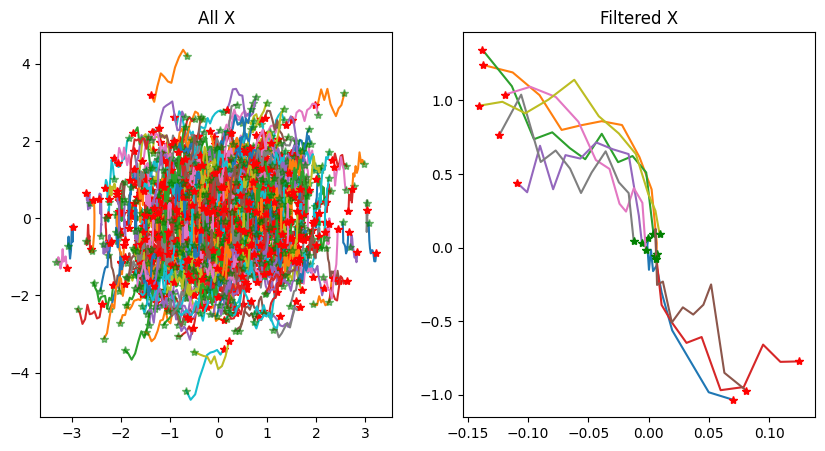

In [1]:
%load_ext autoreload
%autoreload 2
import os, sys, os.path as osp
sys.path.append(osp.dirname(osp.abspath("")))

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

from data_gen import *


cfg_datagen = CfgDataGen(ntraj=int(5e4))
rng = jax.random.PRNGKey(1234)
di = DoubleIntegrator(cfg_datagen, rng)
x0s = jax.random.normal(rng, (cfg_datagen.ntraj, 2))

inte_out = di.rollout(x0s, cfg_datagen.dt)
print(inte_out.xs.shape, inte_out.us.shape)

X = inte_out.xs
U = inte_out.us
filtered_inds = ((jnp.abs(X[:,-1,0]) < 0.1*jnp.abs(X[:,0,0])) &
                 (jnp.abs(X[:,-1,1]) < 0.1*jnp.abs(X[:,0,1])))
X_filtered = X[filtered_inds]


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.set_title("All X")
ax2.set_title("Filtered X")

for i in range(1000):
    ax1.plot(X[i,:,0], X[i,:,1])
    ax1.plot(X[i,0,0], X[i,0,1], 'r*')
    ax1.plot(X[i,-1,0], X[i,-1,1], 'g*', alpha=0.5)
for i in range(X_filtered.shape[0]):
    ax2.plot(X_filtered[i,:,0], X_filtered[i,:,1])
    ax2.plot(X_filtered[i,0,0], X_filtered[i,0,1], 'r*')
    ax2.plot(X_filtered[i,-1,0], X_filtered[i,-1,1], 'g*')
plt.show()

In [1]:

%load_ext autoreload
%autoreload 2
import os, sys, os.path as osp
sys.path.append(osp.dirname(osp.abspath("")))

import jax, jax.numpy as jnp, numpy as np
import matplotlib.pyplot as plt

from utils import get_repo_root
from data_gen import *


''' Now actually generate data'''

for ntraj in ["5e4", "5e7"]:
    
    out_file_dir = osp.join(get_repo_root(), "data")
    out_file_path = osp.join(out_file_dir, f"doubinte_data_{ntraj}.npz")
    if not osp.exists(out_file_dir):
        os.makedirs(out_file_dir)


    cfg_datagen = CfgDataGen(ntraj=int(float(ntraj)))
    rng = jax.random.PRNGKey(1234)
    di = DoubleIntegrator(cfg_datagen, rng)
    x0s = jax.random.normal(rng, (cfg_datagen.ntraj, 2))

    inte_out = di.rollout(x0s, cfg_datagen.dt)

    save_rollout(out_file_path, inte_out)

[16:49:40] INFO     rollout took 0.32 seconds to execute                                               ]8;id=445913;file:///home/kyle/repos/latent_loco/utils.py\utils.py]8;;\:]8;id=817096;file:///home/kyle/repos/latent_loco/utils.py#126\126]8;;\

           INFO     Rollout saved to /home/kyle/repos/latent_loco/data/doubinte_data_5e4.npz |      ]8;id=799793;file:///home/kyle/repos/latent_loco/data_gen.py\data_gen.py]8;;\:]8;id=56505;file:///home/kyle/repos/latent_loco/data_gen.py#109\109]8;;\
                    Size: 0.01 GB                                                                                  

[16:49:41] INFO     rollout took 0.35 seconds to execute                                               ]8;id=680406;file:///home/kyle/repos/latent_loco/utils.py\utils.py]8;;\:]8;id=326101;file:///home/kyle/repos/latent_loco/utils.py#126\126]8;;\

[16:49:46] INFO     Rollout saved to /home/kyle/repos/latent_loco/data/doubinte_data_5e7.npz |      ]8;id=769182;file:///home/kyle/repos/latent_loco/data_gen.py\data_gen.py]8;;\:]8;id=469707;file:///home/kyle/repos/latent_loco/data_gen.py#109\109]8;;\
                    Size: 5.96 GB                                                                                  

## 2. Load Data 

In [7]:

%load_ext autoreload
%autoreload 2
import sys, os.path as osp
sys.path.append(osp.dirname(osp.abspath("")))

import jax, jax.numpy as jnp, numpy as np
import matplotlib.pyplot as plt
import jax_dataloader as jdl

from utils import get_repo_root
from data_gen import *
from rom import *


cfg_train = CfgTrain()
dataset = DoubinteDataset(pred_horizon=cfg_train.max_train_pred_horizon,
                          data_path=osp.join(get_repo_root(), "data/doubinte_data_5e4.npz"))
dataloader = jdl.DataLoader(dataset, backend='pytorch',
                            batch_size=128, shuffle=True)

rom = NNROM(CfgNNDoubinteROM())

batch = next(iter(dataloader))
batch = dataset.collate_fn(batch)

x, xs_next, us= batch['from'], batch['to'], batch['ctrl']

print(f"x type: {type(x)}")
print(f"x.shape, xs_next.shape, us.shape: {x.shape}, {xs_next.shape}, {us.shape}")
print(f"x.device, xs_next.device, us.device: {x.device}, {xs_next.device}, {us.device}")

loss_recon = rom.loss_recon(batch)
loss_reproj = rom.loss_reproj(batch)
loss_fwd = rom.loss_fwd(batch)
loss_bwd = rom.loss_bwd(batch)
loss_recon, loss_reproj, loss_fwd, loss_bwd


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[00:40:28] INFO     Rollout loaded from /home/kyle/repos/latent_loco/data/doubinte_data_5e4.npz |   ]8;id=334539;file:///home/kyle/repos/latent_loco/data_gen.py\data_gen.py]8;;\:]8;id=754156;file:///home/kyle/repos/latent_loco/data_gen.py#115\115]8;;\
                    Size: 0.01 GB                                                                                  

           INFO     DoubinteDataset initialized with 250000 windows/items                           ]8;id=48922;file:///home/kyle/repos/latent_loco/data_gen.py\data_gen.py]8;;\:]8;id=173497;file:///home/kyle/repos/latent_loco/data_gen.py#154\154]8;;\

           INFO              pred_horizon: 4, max_tstep: 10                                         ]8;id=379918;file:///home/kyle/repos/latent_loco/data_gen.py\data_gen.py]8;;\:]8;id=11930;file:///home/kyle/repos/latent_loco/data_gen.py#155\155]8;;\

           INFO              xs_raw_shape: (50000, 11, 2), us_raw_shape: (50000, 10, 1)             ]8;id=447991;file:///home/kyle/repos/latent_loco/data_gen.py\data_gen.py]8;;\:]8;id=433019;file:///home/kyle/repos/latent_loco/data_gen.py#156\156]8;;\

x type: <class 'jaxlib._jax.ArrayImpl'>
x.shape, xs_next.shape, us.shape: (128, 2), (128, 4, 2), (128, 4, 1)
x.device, xs_next.device, us.device: cuda:0, cuda:0, cuda:0


(Array(1.5202646, dtype=float32),
 Array(0.48396048, dtype=float32),
 Array(2.0393598, dtype=float32),
 Array(1.5915982, dtype=float32))

Failed to import warp: No module named 'warp'
Failed to import mujoco.mjx.third_party.mujoco_warp as mujoco_warp: No module named 'warp'


[11:49:23] INFO     Rollout loaded from /home/kyle/repos/latent_loco/data/doubinte_data_5e4.npz |   ]8;id=42119;file:///home/kyle/repos/latent_loco/data_gen.py\data_gen.py]8;;\:]8;id=925220;file:///home/kyle/repos/latent_loco/data_gen.py#115\115]8;;\
                    Size: 0.01 GB                                                                                  

           INFO     DoubinteDataset initialized with 150000 windows/items                           ]8;id=939819;file:///home/kyle/repos/latent_loco/data_gen.py\data_gen.py]8;;\:]8;id=436181;file:///home/kyle/repos/latent_loco/data_gen.py#154\154]8;;\

           INFO              pred_horizon: 6, max_tstep: 10                                         ]8;id=387096;file:///home/kyle/repos/latent_loco/data_gen.py\data_gen.py]8;;\:]8;id=722619;file:///home/kyle/repos/latent_loco/data_gen.py#155\155]8;;\

           INFO              xs_raw_shape: (50000, 11, 2), us_raw_shape: (50000, 10, 1)             ]8;id=730142;file:///home/kyle/repos/latent_loco/data_gen.py\data_gen.py]8;;\:]8;id=756338;file:///home/kyle/repos/latent_loco/data_gen.py#156\156]8;;\

  0%|          | 0/500 [00:00<?, ?it/s]/home/kyle/miniforge3/envs/latent_loco/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Loss: 1.61e-02, LR: 0.00e+00: 100%|██████████| 500/500 [01:45<00:00,  4.74it/s, b_loss=1.57e-02, b_progress=16/17, b_in_ae_warmup=0]


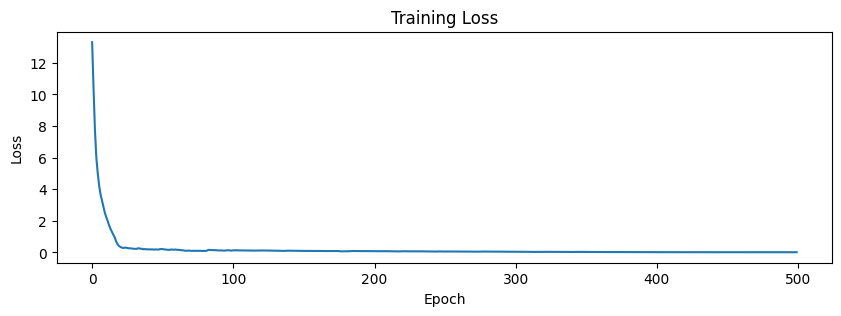

/home/kyle/miniforge3/envs/latent_loco/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[11:51:10] INFO     NNX module saved to /home/kyle/repos/latent_loco/logs/rom_5e4                      ]8;id=380055;file:///home/kyle/repos/latent_loco/utils.py\utils.py]8;;\:]8;id=706033;file:///home/kyle/repos/latent_loco/utils.py#210\210]8;;\

x.shape: (256, 2), xs_next.shape: (256, 6, 2), us.shape: (256, 6, 1)


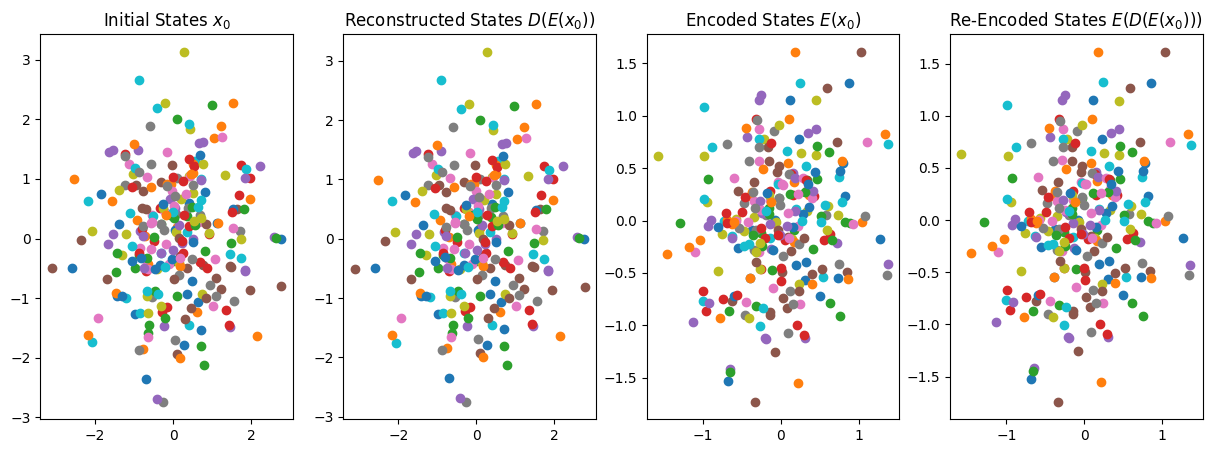

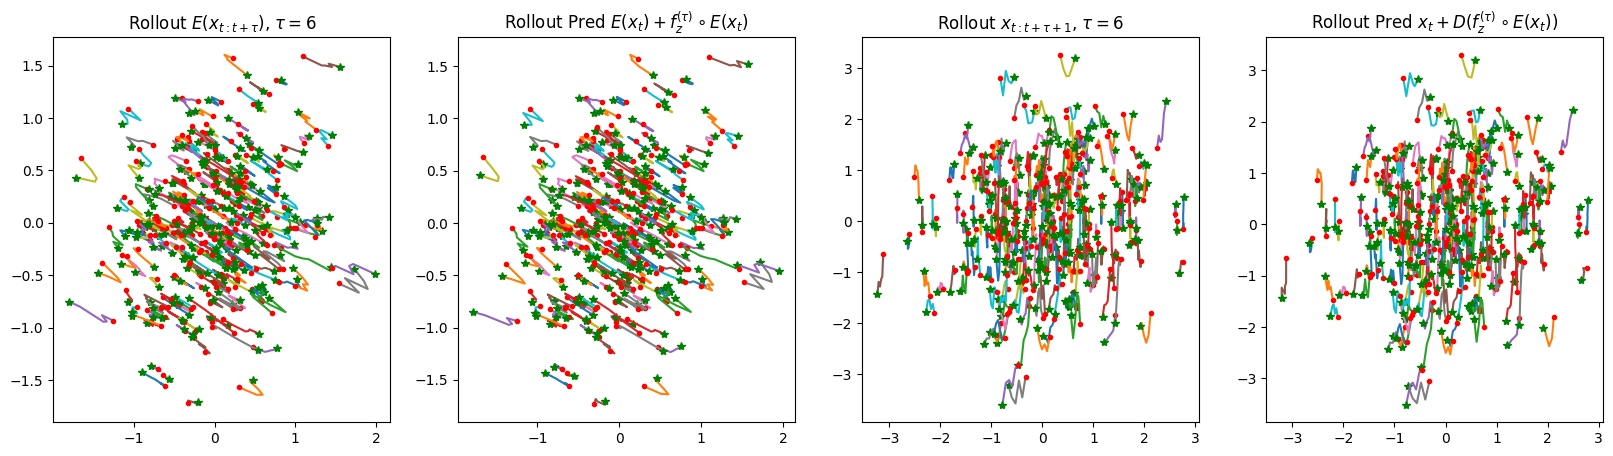

In [1]:
%load_ext autoreload
%autoreload 2
import sys, os.path as osp
sys.path.append(osp.dirname(osp.abspath("")))

import jax, jax.numpy as jnp, numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import random_split

from utils import get_repo_root, save_nnx_module, restore_nnx_module
from data_gen import *
from rom import *


cfg_rom = CfgNNDoubinteROM(encoder_specs=(32,32,32,32), 
                           decoder_specs=(32,32,32,32), 
                           nz=2,
                           fz_specs=(32,32,32))
cfg_train = CfgTrain(num_epochs=500, batch_size=8192, lr=1e-3,
                     ae_warmup_portion=0.0,
                     max_train_pred_horizon=6, 
                     max_eval_pred_horizon=6)
cfg_loss = CfgLoss(recon=1.0, reproj=0.0, fwd=1.0, bwd=1.0)
dataset_size = "5e4"
rng_seed = 0

dataset = DoubinteDataset(pred_horizon=cfg_train.max_train_pred_horizon, 
                          data_path=osp.join(get_repo_root(), f"data/doubinte_data_{dataset_size}.npz"))
train_set, eval_set = random_split(dataset, [cfg_train.train_portion, 1-cfg_train.train_portion])
train_set.collate_fn = DoubinteDataset.collate_fn
eval_set.collate_fn = DoubinteDataset.collate_fn


if train_from_scratch:=True:
    rom = NNROM(cfg_rom, rngs=nnx.Rngs(rng_seed))
    _ = train(rom, train_set, cfg_train, cfg_loss)
    save_nnx_module(rom, f"{get_repo_root()}/logs/rom_{dataset_size}")

else:
    rom = restore_nnx_module(lambda: NNROM(cfg_rom, rngs=nnx.Rngs(rng_seed)),
                            f"{get_repo_root()}/logs/rom_{dataset_size}")

evaluate(rom, eval_set, cfg_train, cfg_loss)